There is a combination of medications that can weaken a patient and sometimes triggering symptoms of diabetes mellitus. In this notebook, I am going to text mine medication names provided in Practice Fusion datasets with the goal to find components of medications that are linked to risk of diabetes type 2. Later in another notebook, I will build a predictive model based on results of this notebook

The process consists in:


1. Convert medication names into document. Each document will be a list of terms
2. Build a vocabulary: This is a hash table of all unique terms found in all documents
3. Calculate how important each term is for each document. I will use [tf-idf](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
4. Remove noisy terms. Noisy terms are those with high tf-idf in as many document as possible. Keeping in mind that the tfidf is value between 0 and 1, we can sum tf-idfs for each term in all documents and set thresholds accordingly. Noisy terms will be added to the list of stop_words
5. With the right vocabulary in hands (initial vocabulary without noisy terms), we will build a table of tf-idfs that will serve as independent variables of the predictive model to be built.

Resources:

- http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [22]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import glob, os, re, random

from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from itertools import groupby
from operator import itemgetter


from fuzzywuzzy import  fuzz, process

from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search

### Cleaning Medication Names

In [23]:
def clean_text(txt,stop_words):
    """
    This functions clean text. It used regex to remove all non alphanumeric characters
    """
    # make sure in put is of type str
    if type(txt) is not str:
        txt = str(txt)
    #lower case
    txt = txt.lower()
    #remove non-alphabetic characters
    txt = re.sub("[^\s\w]"," ",txt).split(" ")
    #remove stop words
    txt = filter(lambda w:not (w in stop_words),txt)
    txt = ' '.join(txt)
    return txt

In [12]:
df0 = pd.read_csv('data/trainingSet/training_SyncPatient.csv')
df0.index = df0.PatientGuid
df0 = df0.drop('PatientGuid',axis=1).sort_index()

df1 = pd.read_csv('data/trainingSet/training_SyncMedication.csv')
df1 = df1[~df1.MedicationName.isnull()]
patient_medication = df1[['PatientGuid','MedicationName']]
patient_medication.MedicationName+=' '
patient_medication = patient_medication.groupby('PatientGuid').sum().sort_index()

In [13]:

tic = dt.datetime.now()
stop_words1 = [' ','','oral','tablet','capsule','release','topical','extended','nasal','inhalation',
              'with','delayed','coated','enteric','aerosol','spray','metoprotol','solution','cream',
              'sodium','syrup','d','adapter','tab','tabs','10','100','104','disintegrating','acid','intravenous',
             '1000','11','12','120','12d','13','15','150','16','1a','1b','1x','20','200','2011','2012','21',
              '23','24','24d','25','28','30','300','325','3350','35','40','400','50','500','60','600','625',
              '2a','64','650','750','75','80','81','900','acids','and','at','device','di','dr','easy','ii','in',
              'iv','mg','non','of','oil','pack','packet','packets','poly','top','subcutaneous','mix','inhalation',
               'and','pak','regular','xl','xr','injection','human']
#clean text
medText = patient_medication.MedicationName.apply(lambda w:clean_text(w,stop_words1))
#create corpus
corpus = medText.values.tolist()
#initialize the term frequency object
tf1 = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words1, ngram_range=(1,1))
#creaet the tf-idf matrix
tf1_matrix = tf1.fit_transform(corpus)
medications_tfidf = pd.DataFrame(tf1_matrix.todense(),
                                 index = patient_medication.index,
                                 columns = sorted(tf1.vocabulary_),)
#save table to csv for later use
medications_tfidf.to_csv('agg_data/medication.csv')
print "process time:", dt.datetime.now() - tic

process time: 0:00:36.182369


Visualize the sum of tf-idf for each term

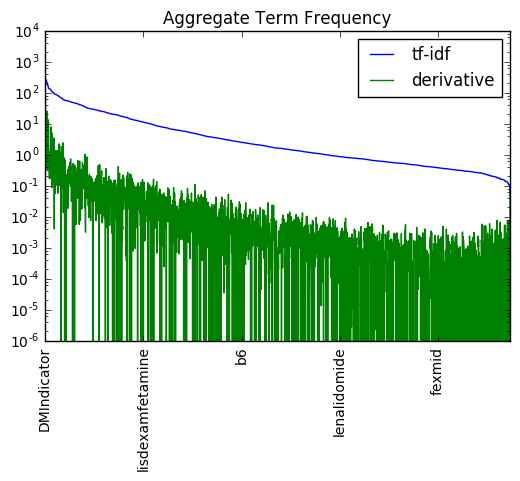

In [24]:
tfidf_agg = medications_tfidf.sum().sort_values(ascending=False)
d_tfidf_agg = -(tfidf_agg - tfidf_agg.shift())#.sort_values()
tfidf_agg.plot()
d_tfidf_agg.plot()
plt.yscale('log')
plt.title("Aggregate Term Frequency")
plt.xticks(rotation=90)
plt.legend(['tf-idf','derivative'])
plt.show()